In [83]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
import csv
import json
import array as array

In [84]:
reader = csv.reader(open('data/intercalibration19C.csv', 'r'))
dict_run_cryst = {}
for row in reader:
    run,energy,crystal,_ = row
    if energy=='149.12' :
        dict_run_cryst[crystal] = run
    
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if energy=='149.12' and  (crystal=='C3' or crystal=='C2' or crystal=='C4' ) :
        dict_run_cryst[crystal] = run
        
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]

In [85]:
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)

In [ ]:
crystal_maps=[]
c = ROOT.TCanvas("c","c",900,900)
c.Divide(5,5)
canvas_num=0
files=[]
grmax=[]
grmaxSimone=[]
file_num = 0
for crystal in naming:
    if crystal in missing:
        canvas_num+=1
    else :
        c.cd(canvas_num+1)
    
        run = dict_run_cryst[crystal]
        files.append(ROOT.TFile("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run))
        tree = files[file_num].Get("h4")
        
        tree.Draw("fit_ampl[%s]:Y:X>>hhnew2_%s(6,-15,15,6,-15,15,0,10000)"%(crystal,crystal),"n_tracks==1","PROFCOLZ")
        htemp2 = ROOT.gPad.GetPrimitive("hhnew2_%s"%crystal)
        xmax =  htemp2.GetMean(1)
        ymax = htemp2.GetMean(2)
        
        tree.Draw("fit_ampl[%s]:Y:X>>hhnew_%s(15,-15,15,15,-15,15,0,10000)"%(crystal,crystal),"n_tracks==1","PROFCOLZ")
        hist2d = ROOT.gPad.GetPrimitive("hhnew_%s"%crystal)
        hist2d.SetTitle(crystal)
        hist2d.GetXaxis().SetTitle('X (mm)')
        hist2d.GetYaxis().SetTitle('Y (mm)')
        hist2d.Draw("PROFCOLZsame")
        crystal_maps.append(hist2d)
    
        
        
        hist2d.GetXaxis().SetRange(hist2d.GetXaxis().FindBin(-10),hist2d.GetXaxis().FindBin(10))
        hist2d.GetYaxis().SetRange(hist2d.GetYaxis().FindBin(-10),hist2d.GetYaxis().FindBin(10))
        
        hist2d.GetXaxis().SetRange(0,hist2d.GetNbinsX())
        hist2d.GetYaxis().SetRange(0,hist2d.GetNbinsY())

        grmax.append(ROOT.TGraph(1,array.array( 'd' ,[xmax]),array.array( 'd' ,[ymax])))
        grmax[file_num].SetMarkerColor(ROOT.kMagenta+2);
        grmax[file_num].SetMarkerStyle(29);
        grmax[file_num].Draw("LPsame")
        
        grmaxSimone.append(ROOT.TGraph(1,array.array( 'd' ,[dict_crystal_centers[crystal][0]]),array.array( 'd' ,[dict_crystal_centers[crystal][1]])))
        grmaxSimone[file_num].SetMarkerColor(2);
        grmaxSimone[file_num].SetMarkerStyle(29);
        grmaxSimone[file_num].Draw("LPsame")
        
        file_num+=1
        canvas_num+=1
c.Draw()
c.SaveAs('plots/crystal_map.pdf')
c.SaveAs('plots/crystal_map.png')


In [ ]:
pos_cut = 3

c = ROOT.TCanvas("c","c",900,900)
c.Divide(5,5)
canvas_num=0
files=[]
file_num=0
chi2s = []
results = []
hists_fits=[]
trees=[]
x,roohist,m,s,a,n,sig,res,frame = [],[],[],[],[],[],[],[],[]
print 'here'
#for crystal_num in range(0,len(naming)):
#for crystal_num in range(0,3):
#for crystal in naming:
for crystal in ['A3','C3','B3']:
    if crystal in missing:
        canvas_num+=1
    else :
        c.cd(canvas_num+1) 
        print canvas_num
        
        run = dict_run_cryst[crystal]
        files.append(ROOT.TFile("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run))
        trees.append(files[file_num].Get("h4"))
    
        hist_ampl = ROOT.TH1F("hist_ampl_%s"%crystal,"hist_ampl_%s"%crystal,300,2000,8000)
        trees[file_num].Draw("fit_ampl[%s]>>hist_ampl_%s"%(crystal,crystal),"n_tracks==1 && fabs(X-(%.2f))<%.2f && fabs(Y-(%.2f))<%.2f"%(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut,pos_cut),"")
        peak_position = hist_ampl.GetXaxis().GetBinCenter(hist_ampl.GetMaximumBin())

    
        x.append(RooRealVar("fit_ampl_%s"%crystal,"fit_ampl_%s"%crystal,peak_position*0.8,peak_position*1.2))
        roohist.append(RooDataHist("roohist_fit_%s"%crystal,"roohist_fit_%s"%crystal,RooArgList(x[file_num]),hist_ampl))

        m.append(RooRealVar("mean_%s"%crystal,"mean_%s"%crystal,peak_position,peak_position*0.8,peak_position*1.2))
        s.append(RooRealVar("sigma_%s"%crystal,"sigma_%s"%crystal,60,0,500))
        a.append(RooRealVar("alpha_%s"%crystal,"alpha_%s"%crystal,0.5,0,10))
        n.append(RooRealVar("exp_%s"%crystal,"exp_%s"%crystal,7,0,150))
        sig.append(RooCBShape("signal_%s"%crystal,"signal_%s"%crystal,x[file_num],m[file_num],s[file_num],a[file_num],n[file_num]))

        res.append(sig[file_num].fitTo(roohist[file_num]))#RooFit.Save())
        res.Print()

        frame.append(x[file_num].frame())
        roohist[file_num].plotOn(frame[file_num],RooFit.Name("roohist_%s"%crystal))
        sig[file_num].plotOn(frame[file_num],RooFit.Name("signal_%s"%crystal))
        frame[file_num].Draw()
        hists_fits.append(hist_ampl)
        chi2s.append(frame[file_num].chiSquare("signal_%s"%crystal,"roohist_%s"%crystal,4)) # 4 = nFitParameters from CB
        
        canvas_num+=1
        file_num+=1
c.Draw()
c.SaveAs('plots/fits.pdf')
c.SaveAs('plots/fits.png')

1 13405 B5
2 13407 C5
3 13408 D5
6 13404 B4
7 13378 C4
8 13409 D4
10 13400 A3
11 13403 B3
12 13416 C3
13 13410 D3
14 13415 E3
15 13399 A2
16 13402 B2
17 13377 C2
18 13411 D2
19 13414 E2
20 13398 A1
21 13401 B1
22 13406 C1
23 13412 D1
24 13413 E1


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


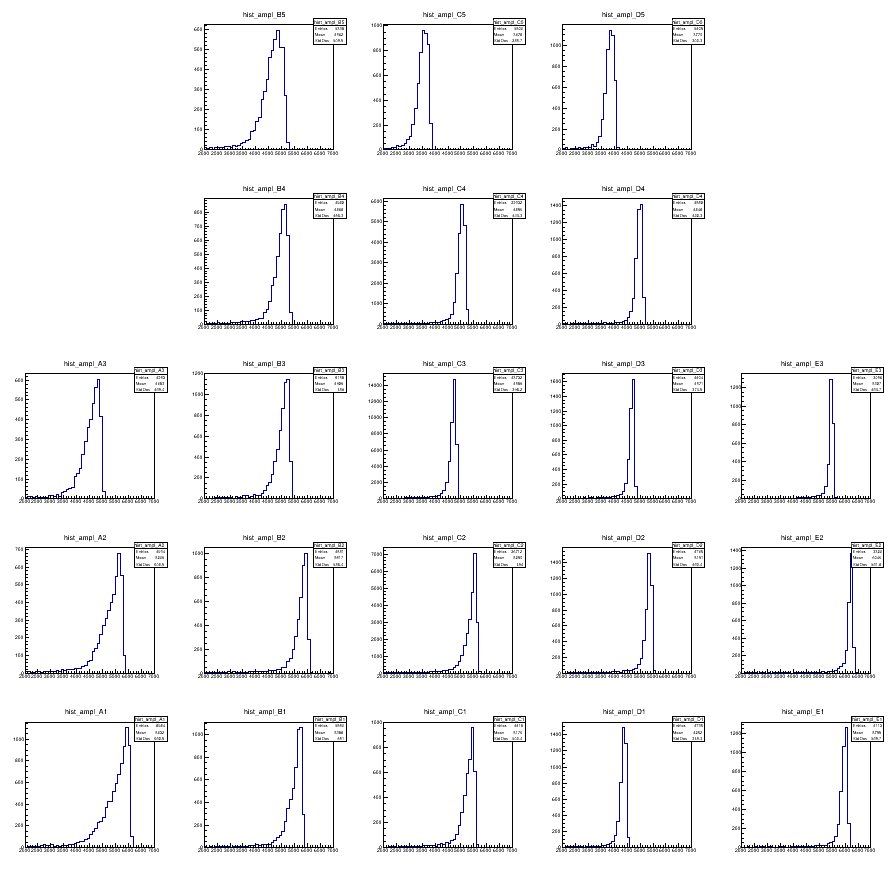

In [5]:
pos_cut = 3

c = ROOT.TCanvas("c","c",900,900)
c.Divide(5,5)
canvas_num=0
files=[]
file_num=0
chi2s = []
results = []
hists_fits=[]
for crystal in naming:
    if crystal in missing:
        canvas_num+=1
    else :
        c.cd(canvas_num+1) 
        run = dict_run_cryst[crystal]
        files.append(ROOT.TFile("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run))
        tree = files[file_num].Get("h4")
    
        hist_ampl = ROOT.TH1F("hist_ampl_%s"%crystal,"hist_ampl_%s"%crystal,50,2000,7000)
        tree.Draw("fit_ampl[%s]>>hist_ampl_%s"%(crystal,crystal),"n_tracks==1 && fabs(X-(%.2f))<%.2f && fabs(Y-(%.2f))<%.2f"%(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut,pos_cut),"")
       # tree.Draw("fit_ampl[%s]>>hist_ampl_%s"%(crystal,crystal),"n_tracks==1","")
        peak_position = hist_ampl.GetXaxis().GetBinCenter(hist_ampl.GetMaximumBin())
        
        hist_ampl.Draw()
        hists_fits.append(hist_ampl)
        
        canvas_num+=1
        file_num+=1

c.Draw()

## Equalize response for 3x3 matrix wrt to C3

In [5]:
with open('output/intercarlibration_results.json') as json_file:
    fit_results = json.load(json_file)

In [6]:
dict_crystals_calibration = {}

for key in fit_results:
    dict_crystals_calibration[key] = fit_results['C3'][1:2][0][0]/fit_results[key][1:2][0][0]

In [7]:
##Read C3 energy scans
dict_C3_energy_scan = {}
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if crystal=='C3' :
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)

In [ ]:
pos_cut = 3

crystal_maps=[]
c = ROOT.TCanvas("c","c",900,900)
c.Divide(1,5)
canvas_num=0
files=[]
file_num = 0
chi2s = []
results = []
hists_fits=[]
trees=[]
x,roohist,m,s,a,n,sig,res,frame = [],[],[],[],[],[],[],[],[]
dict_energy_means={}
for energy in dict_C3_energy_scan.keys():
        canvas_num+=1
    else :
        c.cd(canvas_num+1)
    
        runs = dict_C3_energy_scan[energy]
        tree = ROOT.TChain("h4")
        for run in runs:
            tree.Add("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run)

        hist_ampl = ROOT.TH1F("hist_ampl_%s"%energy,"hist_ampl_%s"%energy,300,2000,8000)
        trees[file_num].Draw("fit_ampl[%s]>>hist_ampl_%s"%(energy,energy),"n_tracks==1 && fabs(X-(%.2f))<%.2f && fabs(Y-(%.2f))<%.2f"%(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut,pos_cut),"")
        peak_position = hist_ampl.GetXaxis().GetBinCenter(hist_ampl.GetMaximumBin())
        ymax_value = hist_ampl.GetMaximum()


        x.append(RooRealVar("fit_ampl_%dGeV"%round(float(energy),-1),"fit_ampl_%dGeV"%round(float(energy),-1),peak_position*0.8,peak_position*1.2))
        roohist.append(RooDataHist("roohist_fit_%s"%energy,"roohist_fit_%s"%energy,RooArgList(x[file_num]),hist_ampl))

        m.append(RooRealVar("mean_%s"%energy,"mean_%s"%energy,peak_position,peak_position*0.8,peak_position*1.2))
        s.append(RooRealVar("sigma_%s"%energy,"sigma_%s"%energy,60,0,500))
        a.append(RooRealVar("alpha_%s"%energy,"alpha_%s"%energy,0.5,0,10))
        n.append(RooRealVar("exp_%s"%energy,"exp_%s"%energy,7,0,150))
        sig.append(RooCBShape("signal_%s"%energy,"signal_%s"%energy,x[file_num],m[file_num],s[file_num],a[file_num],n[file_num]))

        res.append(sig[file_num].fitTo(roohist[file_num]))#RooFit.Save())
        #res.Print()

        frame.append(x[file_num].frame())
        roohist[file_num].plotOn(frame[file_num],RooFit.Name("roohist_%s"%energy))
        sig[file_num].plotOn(frame[file_num],RooFit.Name("signal_%s"%energy))
        hists_fits.append(hist_ampl)
        chi2s.append(frame[file_num].chiSquare("signal_%s"%energy,"roohist_%s"%energy,4)) # 4 = nFitParameters from CB

        sig[file_num].paramOn(frame[file_num],RooFit.Layout(0.65,0.99,0.8))
        frame[file_num].getAttText().SetTextSize(0.03)

        txt_chi2 = ROOT.TText(peak_position*0.83,ymax_value*0.95,"Chi2 = %.1f"%chi2s[file_num])
        txt_chi2.SetTextSize(0.04)
        txt_chi2.SetTextColor(ROOT.kRed)
        frame[file_num].addObject(txt_chi2)

        frame[file_num].Draw()

        dict_energy_means[energy] = ['CBmean',[m[file_num].getVal(),m[file_num].getError()],['CBsigma',s[file_num].getVal(),s[file_num].getError()]]

        canvas_num+=1
        file_num+=1
c.Draw()
c.SaveAs('plots/C3_fits_cut%dmm.pdf'%pos_cut)
c.SaveAs('plots/C3_fits_cut%dmm.png'%pos_cut)

In [89]:
with open('output/energyscans_C3_results.json') as json_file:
    fit_C3_results = json.load(json_file)

In [90]:
energies = [float(item) for item in fit_C3_results.keys()]
means_C3 = [fit_C3_results[str(item)][1:2][0][0] for item in energies]
means_unc_C3 = [fit_C3_results[str(item)][1:2][0][1] for item in energies]

ADC to GeV convesion factor = 0.025


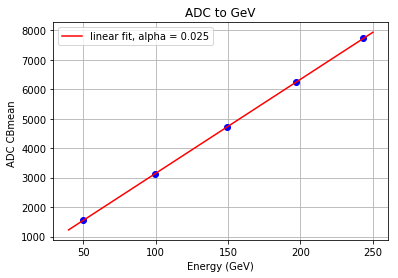

In [82]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def linear_func(x, a, b):
    return a * x + b

fig, ax = plt.subplots()
ax.plot(energies, means_C3,'bo' )
popt, pcov = curve_fit(linear_func, energies, means_C3)

shower_energy = 0.79
conversion_factor = 0.79/popt[0]
print 'ADC to GeV convesion factor = %.3f'%conversion_factor

xfine = np.linspace(40., 250., 1000)  # define values to plot the function for
ax.plot(xfine, linear_func(xfine, popt[0], popt[1]), 'r-',label='linear fit, alpha = %.3f'%conversion_factor)
ax.set(xlabel='Energy (GeV)', ylabel='ADC CBmean ',
       title='ADC to GeV')

plt.legend()
plt.grid()
plt.show()
fig.savefig('plots/ADC_to_GeV.png')
fig.savefig('plots/ADC_to_GeV.pdf')


dict_crystals_calibration['conversion_factor'] = conversion_factor
with open('output/conversion_factor.json', 'w') as fp:
    json.dump(dict_crystals_calibration, fp)

### Sum of calibrated energies in matrix 3x3 vs energy

In [86]:
with open('output/energy_sums.json') as json_file:
    energy_sums = json.load(json_file)

fit params :  -0.0011500682609396546 0.18508673338555565
fit params :  -0.003643384227921856 0.8578421243004611


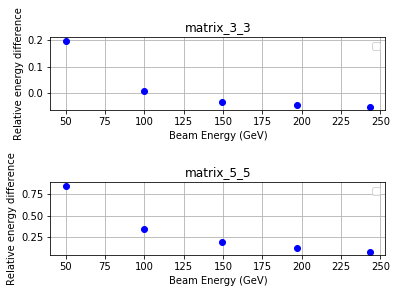

In [125]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def linear_func(x, a, b):
    return a * x + b

fig, ax = plt.subplots(2)
for  num,which_matrix in enumerate(['matrix_3_3','matrix_5_5']):
    energy_sums_list = [energy_sums[which_matrix][str(item)] for item in energies]
    energy_rel_diff = []
    for i in range(0,len(energies)):
        energy_rel_diff.append((energy_sums_list[i]-energies[i])/energies[i])
    ax[num].plot(energies, energy_rel_diff,'bo' )
    popt, pcov = curve_fit(linear_func, energies,energy_rel_diff )
    xfine = np.linspace(40., 250., 1000)  # define values to plot the function for
   # ax[num].plot(xfine, linear_func(xfine, popt[0], popt[1]), 'r-',label='linear fit')
    ax[num].set(xlabel='Beam Energy (GeV)', ylabel='Relative energy difference',
       title='%s'%which_matrix)

    print 'fit params : ',popt[0],popt[1]
    ax[num].grid()
    ax[num].legend()
    
plt.subplots_adjust(hspace=1.)    
plt.show()
fig.savefig('plots/sum_energy_matrices.png')
fig.savefig('plots/sum_energy_matrices.pdf')